# Advanced Lane Finding Project 

By Pablo Sauras Perez

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## 1. Compute the camera calibration using chessboard images
This code is was available in 'examples/example.ipynb'

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# chessboard
ny = 6
nx = 9

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'output_images/calibration_corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow(write_name,img)
        cv2.waitKey(50)
        
cv2.destroyAllWindows()

### Calibrate, Calculate Distortion Coefficients and test undistorsion on an image
This code is from 'CarND-Camera-Calibration'

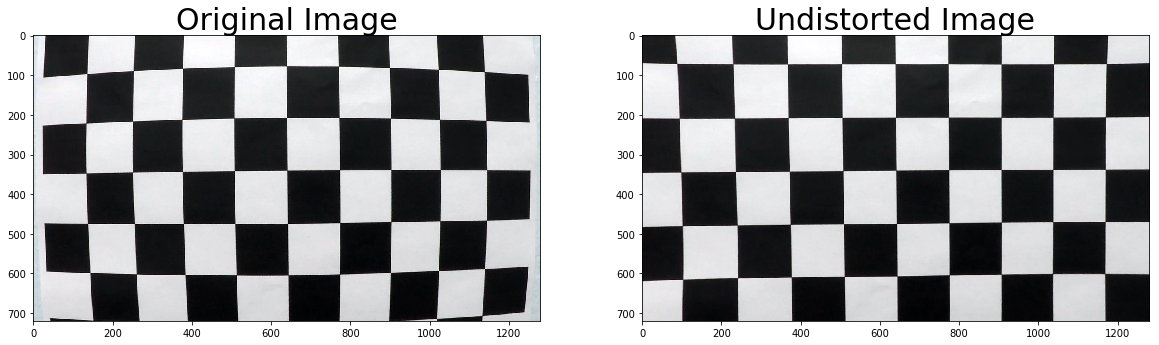

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/undistorded_calibration.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#I apply mtx and dist to each new frame
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Pipeline (single images)

## 2. Apply a distortion correction to raw images

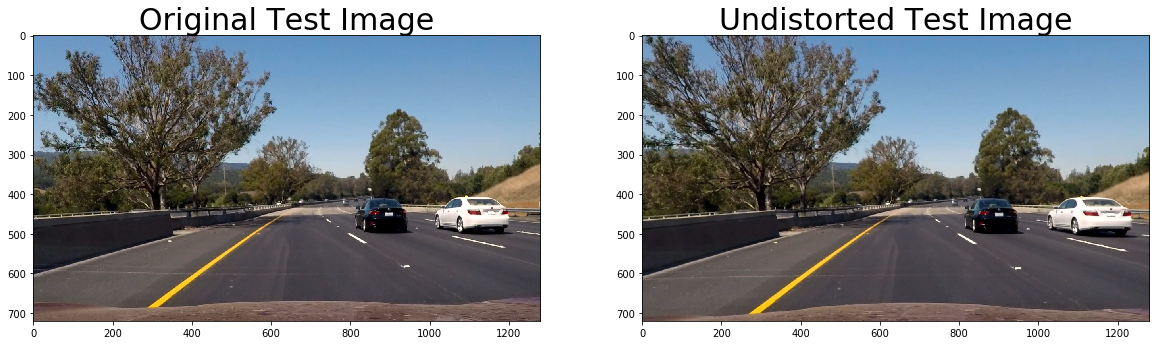

In [126]:
# Test undistortion on an image
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Calculate distortion coefficients
dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite('output_images/undistorded_test.jpg',cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Test Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Test Image', fontsize=30)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

This is the Thresholding step. Here I want to use various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

In [127]:
# Edit this function to create your own pipeline.
def pipeline_threshold(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    
    r_channel = img[:,:,2]
    g_channel = img[:,:,1]
    b_channel = img[:,:,0]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(v_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel_mag = np.uint8(255*gradmag/np.max(gradmag))
    
    thresh_d=(0.5, 1.3)
    
    #direction of the gradient
    direction =  np.arctan2(abs_sobely, abs_sobelx)
        
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]))] = 1
    
    # Threshold magnitude
    s_mag_binary = np.zeros_like(scaled_sobel_mag)
    s_mag_binary[((scaled_sobel_mag >= sx_thresh[0]) & (scaled_sobel_mag <= sx_thresh[1]))] = 1
    
    # Threshold x gradient
    s_dir_binary = np.zeros_like(scaled_sobel)
    s_dir_binary[((direction >= thresh_d[0]) & (direction <=  thresh_d[1]))] = 1
    
    #sxbinary[(sxbinary == 1) | ((s_mag_binary == 1) & (s_dir_binary == 1))] = 1
    
    #binary_output_direction = np.zeros_like(direction)
    #binary_output_direction[(direction_direction >= thresh_d[0]) & (direction_direction <=  thresh_d[1])] = 1
    
    # Threshold color channel S
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_thresh = (15, 100)
    # Threshold color channel H
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    v_thresh = (220, 255)
    # Threshold color channel V
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    l_thresh = (15, 100)
    # Threshold color channel H
    #l_binary = np.zeros_like(l_channel)
    l_binary = l_channel
    
    #l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = np.dstack(( v_binary, sxbinary, s_binary))
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[((s_binary == 1) & (s_dir_binary == 1) & (s_mag_binary == 1)) | (sxbinary == 1)] = 1
    #combined_binary[((s_binary == 1) & (h_binary == 1)) | ((sxbinary == 1) & (s_dir_binary == 1)) ] = 1
    combined_binary[((sxbinary == 1) | (v_binary == 1))] = 1
    #combined_binary[(v_binary == 1) ] = 1
    #color_binary = v_channel
    color_binary = combined_binary
    
    
    return color_binary

Apply threshold pipeline and show one of the test results

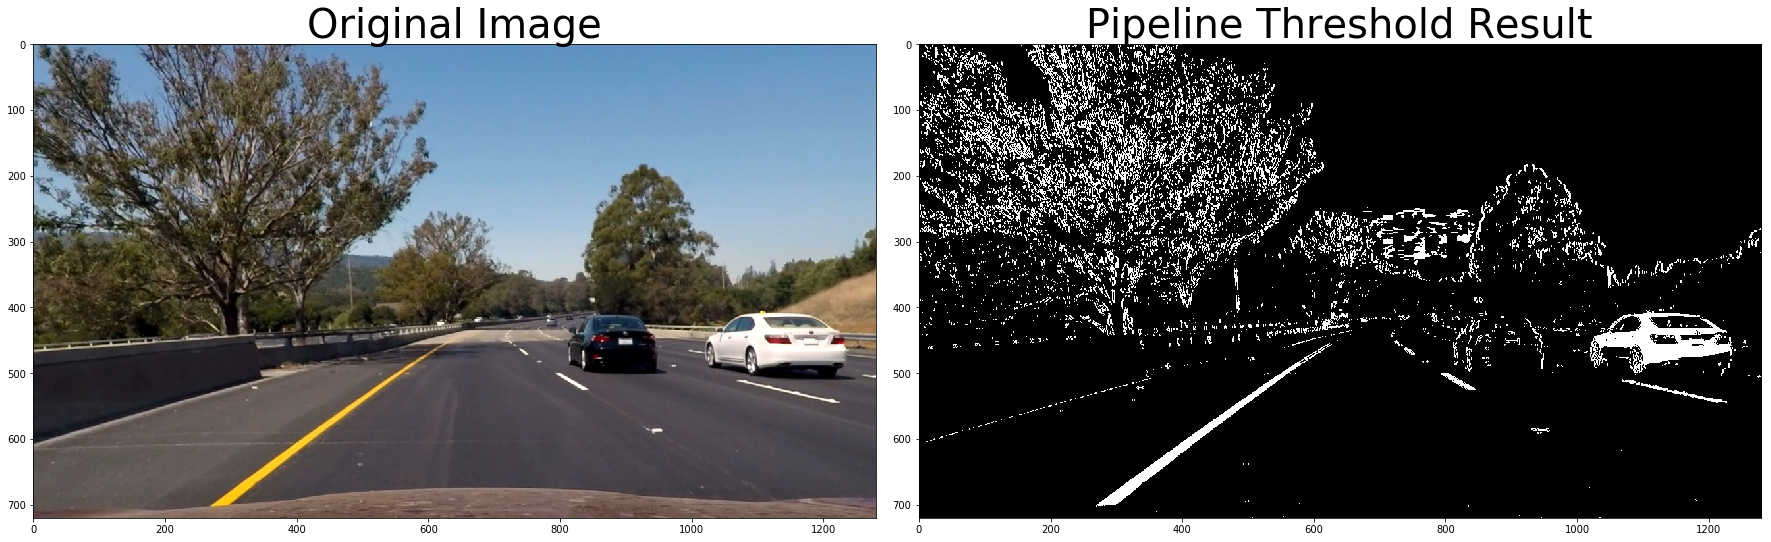

In [128]:
image = dst
undst = dst
color_binary = pipeline_threshold(image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary, cmap = 'gray')
ax2.set_title('Pipeline Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [129]:
#I already have mtx --> Calibration Matrix
# and dist --> Distortion Coeficients
#from the camera calibration of step 1... so I use them

def corners_unwarp(img, mtx, dist):

    # Undistort using mtx and dist   
    undst = cv2.undistort(img, mtx, dist, None, mtx)  
    img_size =(undst.shape[1], undst.shape[0])
    
    #top-right
    #bottom-right
    #bottom-left
    #top-left
    
    #source points (trapezoid)  
    src = np.float32(
    [[580, 460],
     [195, 720],
     [1127, 720],
     [705, 460]])
    
   
    #destination points (a rectangle)        
    dst = np.float32(
    [[200, 0],
     [200, 720],
     [950, 720], 
     [950, 0]])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #calculate the inverse as well
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undst, M, img_size, flags=cv2.INTER_LINEAR)
 
    return warped, M, Minv, src, dst

Apply it the perspective transform

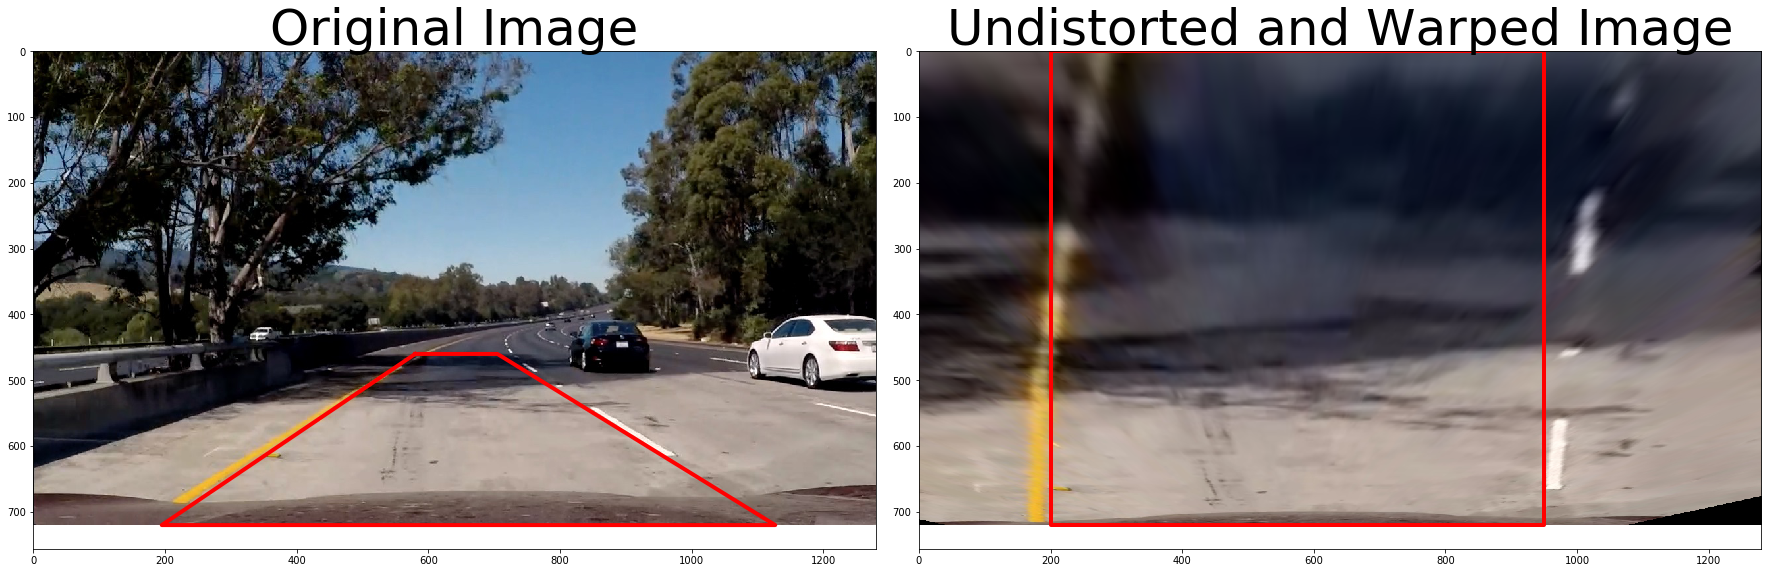

In [130]:
# Test on an image where lines are straight
img = cv2.imread('test_images/test5.jpg')

top_down, perspective_M, perspective_Minv, src, dst = corners_unwarp(img, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB))
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now I apply perspective transform to rectify binary image

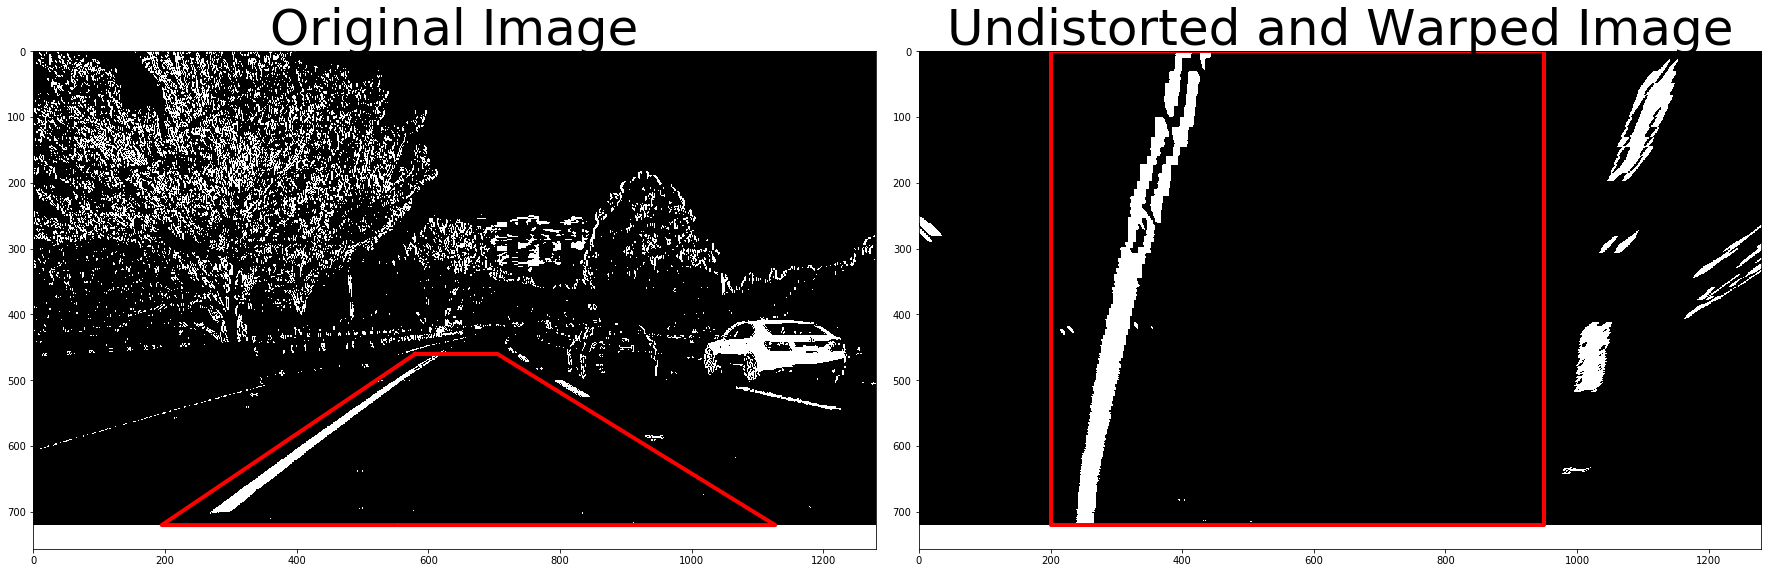

In [131]:
binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)

x_src = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
y_src = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]

x_dst = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
y_dst = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary, cmap='gray')
ax1.plot(x_src, y_src, 'r-', lw=4)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(binary_warped, cmap='gray')
ax2.plot(x_dst, y_dst, 'r-', lw=4)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Detect lane pixels and fit to find the lane boundary.

In [132]:
def lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix):
    
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    #nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 100
    # Set minimum number of pixels found to recenter window
    #minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy

### Call the function

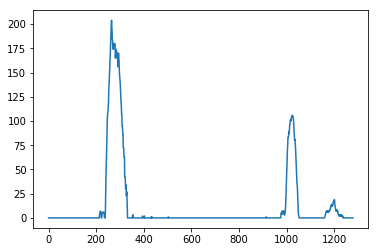

In [133]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

#Call the function
nwindows = 9
margin = 100
minpix = 50

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
    
left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)

### Visualization


(720, 0)

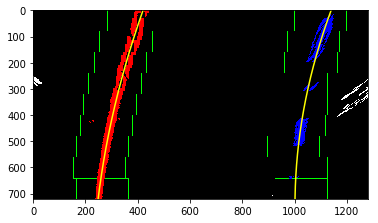

In [134]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0], binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Skip the sliding windows step once you know where the lines are

In [135]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def next_window_lane_boundaries(binary_warped, left_fit, right_fit, margin):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #margin = margin
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_lane_inds, left_fitx, right_lane_inds, right_fitx, ploty

### Call the function

In [136]:
#Call to the function
margin = 100
left_lane_inds, left_fitx, right_lane_inds, right_fitx, ploty = next_window_lane_boundaries(binary_warped, left_fit, right_fit, margin)

## Visualize as well

(720, 0)

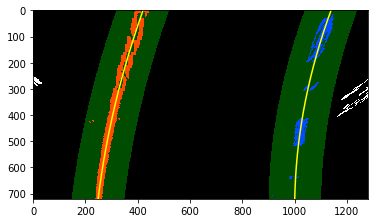

In [137]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 6. Determine the curvature of the lane and vehicle position with respect to center

First I do Radius in Pixels

In [138]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def rad_cur_px(ploty, y_eval, left_fit, right_fit):
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print('Left Radius: ', left_curverad)
    print('Right Radius: ', right_curverad)
    
    return left_curverad, right_curverad

Call the function

In [139]:
y_eval = np.max(ploty)
left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

Left Radius:  3183.98506648
Right Radius:  2021.49514744


Now we have to convert this to the real world space. 
Assume (as indicated in the lesson) hat if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [140]:
def rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix):


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Left curvature: ', left_curverad, 'm')
    print('Right curvature: ', right_curverad, 'm')

    R_avg = (left_curverad + right_curverad)/2

    curv_str = "Radius of Curvature: %im" % abs(R_avg)
    print(curv_str)
    
    return curv_str, left_fit_cr, right_fit_cr

Call the function

In [141]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/750 # meters per pixel in x dimension
curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)

Left curvature:  1095.99192739 m
Right curvature:  728.557773675 m
Radius of Curvature: 912m


## Offset calculation

In [142]:
def lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix):
    
    #Calculate distance at the bottom of the image
    left_fit_cr_eval = left_fit_cr[0]*y_eval*ym_per_pix**2 + left_fit_cr[1]*y_eval*ym_per_pix + left_fit_cr[2]
    right_fit_cr_eval = right_fit_cr[0]*y_eval*ym_per_pix**2 + right_fit_cr[1]*y_eval*ym_per_pix + right_fit_cr[2]

    image_center = (binary_warped.shape[1]/2)*xm_per_pix #Convert to m
    lane_center = (right_fit_cr_eval + left_fit_cr_eval)/2 #Already in m

    offset = image_center - lane_center

    if offset > 0:
        offset_str = "Vehicle is %.2fm left of center" % abs(offset)
        print(offset_str)
    elif offset < 0:
        offset_str = "Vehicle is %.2fm right of center" % abs(offset)
        print(offset_str)
    else:
        offset_str = "Vehicle is at center"
        print(offset_str)   
        
    return offset_str

Call the function

In [143]:
offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)

Vehicle is 0.59m left of center


## 7. Warp the detected lane boundaries back onto the original image.

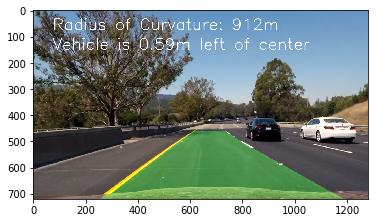

In [144]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

   
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,curv_str,(75, 75), font, 2,(255,255,255),2, cv2.LINE_AA)
cv2.putText(result,offset_str,(75, 150), font, 2,(255,255,255),2, cv2.LINE_AA)
plt.imshow(result)

## Pipeline (Video)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
#Image
#mtx --> Calibration Matrix
#dist --> Distortion Coeficients
def process_image(image):
    #TODO: my code here
    #result = image
    
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    img = image
    #1 . Distortion correction on images
    #img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Calculate distortion coefficients
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #2. Color / Gradient thresholding
    color_binary = pipeline_threshold(undst)
    
    #3. Unwrap  
    binary_warped, perspective_M, perspective_Minv, src, dst = corners_unwarp(color_binary, mtx, dist)
    
    #4. detect lane pixels to find lane boundary
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    #Call the function
    nwindows = 9
    margin = 100
    minpix = 50

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    
    left_lane_inds, left_fit, right_lane_inds, right_fit, nonzerox, nonzeroy = lane_boundary_sl_wi(binary_warped, histogram, nwindows, margin, minpix)
    
    #5. Skip Slidding Window once I know where the lanes are
    margin = 100
    left_lane_inds, left_fitx, right_lane_inds, right_fitx, ploty = next_window_lane_boundaries(binary_warped, left_fit, right_fit, margin)
    
    #6. Determine Rad Curvature
    # In pixels
    y_eval = np.max(ploty)
    left_curverad, right_curverad = rad_cur_px(ploty, y_eval, left_fit, right_fit)

    #In meters
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    curv_str, left_fit_cr, right_fit_cr = rad_cur_m(ploty, y_eval, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    
    #7. Calculate lateral offset
    offset_str = lateral_offset(binary_warped, left_fit_cr, right_fit_cr, xm_per_pix, ym_per_pix)
    
    #Plot results
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
    #plt.text(100, 75, curv_str, color='white')
    #plt.text(100, 150, offset_str, color='white')
    #plt.imshow(result)
    #result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,curv_str,(75, 75), font, 2,(255,255,255),2, cv2.LINE_AA)
    cv2.putText(result,offset_str,(75, 150), font, 2,(255,255,255),2, cv2.LINE_AA)
    return result

In [ ]:
output_clip = "output_images/project_video_result.mp4"
clip = VideoFileClip("project_video.mp4")

clip_result = clip.fl_image(process_image)

%time clip_result.write_videofile(output_clip, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))